In [215]:
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
from pyproj import Proj
from IPython.display import display

farm_df contains locations of wind farms. If any are missing,we can use a representative turbine from each farm

In [2]:
usa_farm_df = pd.read_csv('data/openei-wind-farm-sites.csv')
usa_farm_df.head()

,Facility Name,Facility,FacilityType,Owner,Developer,EnergyPurchaser,Place,GeneratingCapacity,NumberOfUnits,CommercialOnlineDate,WindTurbineManufacturer,FacilityStatus,Coordinates
0,251 Wind,251 Wind,NaN,NaN,NaN,NaN,"Kern County, CA",18.43 MW,194.0,1987.0,Vestas,NaN,"35.0861°, -118.3533°"
1,3-D Metals,3-D Metals,Definition:Small Scale Wind,NaN,NaN,NaN,Valley City OH,0.1 MW,1.0,2009.0,Northern Power Systems,In Service,"41.2481°, -81.8831°"
2,30 MW Iowa DG Portfolio,30 MW Iowa DG Portfolio,NaN,NaN,NaN,NaN,"Story County, IA",30 MW,10.0,2017.0,Nordex,NaN,"42.0136°, -93.5181°"
3,6th Space Warning Squadron,6th Space Warning Squadron,NaN,NaN,NaN,NaN,"Barnstable County, MA",3.36 MW,2.0,2013.0,GE Wind,NaN,"41.7525°, -70.5417°"
4,AB Tehachapi Wind Farm,AB Tehachapi,Commercial Scale Wind,Coram Energy,AB Energy,Southern California Edison Co,"Tehachapi, California",6.97 MW,31.0,1992.0,Vestas,In Service,"35.0533°, -118.2686°"


In [3]:
#filter by state (state abbrev is always at end of 'Place')
def filter_state(place,state):
    try:
        if place[-1] == ' ':
            print('bad')
        return place[-2:] == state
    except:
        print('cannot parse ',place)
        return False

farm_df = usa_farm_df[usa_farm_df['Place'].apply(lambda x: filter_state(x,'CA'))]\
    .copy().reset_index() #make this a new df

cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan


In [4]:
#extract latitude and longitude as floats
def parse_coords(in_s):
    try:
        s_list = str(in_s).split(',')
        return  [float(s[:-1]) for s in s_list]
    except:
        print('cannot parse ',in_s)
        return [np.nan,np.nan]
farm_df['latitude'], farm_df['longitude'] = list(zip(*farm_df['Coordinates'].apply(parse_coords)))

In [5]:
farm_df.head()

,index,Facility Name,Facility,FacilityType,Owner,Developer,EnergyPurchaser,Place,GeneratingCapacity,NumberOfUnits,CommercialOnlineDate,WindTurbineManufacturer,FacilityStatus,Coordinates,latitude,longitude
0,0,251 Wind,251 Wind,NaN,NaN,NaN,NaN,"Kern County, CA",18.43 MW,194.0,1987.0,Vestas,NaN,"35.0861°, -118.3533°",35.0861,-118.3533
1,19,Aero Turbine,Aero Turbine,Commercial Scale Wind,AeroTurbine Energy Company,NaN,NaN,Riverside County CA,5 MW,39.0,1989.0,NaN,In Service,"33.7436°, -115.9925°",33.7436,-115.9925
2,30,Alite Wind Farm,Alite Wind Farm,Commercial Scale Wind,Terra-Gen Power LLC,Allco/Oak Creek Energy,California Portland Cement,Mojave CA,24 MW,8.0,2008.0,Vestas,In Service,"35.0406°, -118.2994°",35.0406,-118.2994
3,32,Alta I,Alta I,Commercial Scale Wind,Terra-Gen Power LLC,Terra-Gen Power LLC,Southern California Edison Co,Tehachapi Pass CA,150 MW,100.0,2010.0,GE Energy,In Service,"35.0192°, -118.3031°",35.0192,-118.3031
4,33,Alta II (Vestas),Alta II (Vestas),Commercial Scale Wind,Terra-Gen Power LLC,Terra-Gen Power LLC,Southern California Edison Co,Tehachapi Pass CA,150 MW,50.0,2010.0,Vestas,In Service,"35.0192°, -118.3031°",35.0192,-118.3031


In [6]:
#might want to filter by online date depending on age of other data
print(farm_df['CommercialOnlineDate'].max())

2018.0


In [7]:
#load power generation data for years where enough is available
#gen_years = [14,15,16,17,18,19]
gen_years = [19]
gen_df = pd.concat(
    [pd.read_csv('data/ca-power-gen-{0:d}.csv'.format(yr), thousands=',') for yr in gen_years],
    axis=0)
gen_df.head()

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116
1,2019.0,BP Wind Energy North America,50553,W0391,"Edom Hills Project 1, LLC",CA,20.0,28500,28500
2,2019.0,CalWind Resources Inc,10191,W0284,Wind Resource I (Calwind Wind Resource I),CA,8.7,14038,14038
3,2019.0,CalWind Resources Inc,54909,W0320,Wind Resource II (Calwind),CA,20.0,47619,47619
4,2019.0,Coram California Development LP,57962,W0408,"Coram California Development, LP",CA,102.0,247038,247038


In [8]:
#turbine data (ostensibly for 2020)
usa_turb_df = pd.read_csv('data/uswtdbCSV/uswtdb_v3_0_1_20200514.csv')
ca_turb_df = usa_turb_df[usa_turb_df.t_state == 'CA']
#points = [Point(xy) for xy in zip(ca_turbines['xlong'],ca_turbines['ylat'])]

In [294]:
ca_turb_df.head().columns

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu',
       't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr',
       't_conf_loc', 't_img_date', 't_img_srce', 'xlong', 'ylat'],
      dtype='object')

In [9]:
farm_names, gen_names, turb_names = [
    df[fname].unique() for (df,fname) in zip([farm_df,gen_df,ca_turb_df],['Facility Name','Plant Name','p_name'])
]
print(len(farm_names),len(gen_names),len(turb_names))

166 117 135


In [261]:
def match_str(s,s_match):
    if s_match in s:
        return True
    #print(s_match[-1])
    if len(s) >= len(s_match[:-1]) and s_match[-1] == ' ': #check end, without space
        #if s == 'Alta I' and s_match == 'Alta I ':
            #print('|' + s[-len(s_match[:-1]):] + '|')
            #print('|' + s_match[:-1] + '|')
        if s[-len(s_match[:-1]):] == s_match[:-1]:
            return True
    return False
def vec_str_in(s_arr,s_match):
    return [match_str(str(s),s_match) for s in s_arr]
def vec_all_str_in(s_arr,s_match_list):
    return [np.all([match_str(str(s),s_match) for s_match in s_match_list]) for s in s_arr]

In [182]:
rn_list = 'I,II,III,IV,V,VI,VII,VIII,IX,X'.split(',')
def flatten(list_of_lists):
    return [y for x in list_of_lists for y in x]
def make_rn_names(root,n):
    return [[root, ' ' + rn + ' '] for rn in rn_list[:n]]
names = [
    ['251'],
    *[['Alta ' + rn + ' '] for rn in rn_list],
    ['Edom'],
    ['Coram','Energy'],
    ['Wintec' , ' '],['Wintec II '], #how to distinguish I, II?
    ['Windstar'],
    *make_rn_names('Pinyon',2),
    ['Mojave'],
    ['Ocotillo'], #we have octotillo, octotillo expansion listed separately in farm_df
    ['Manzana'],
    ['High'],
    ['North Sky'],
    ['Golden Hills'],
    ['Dutch'],
    ['Voyager'],
    *make_rn_names('Shiloh',3),
    *flatten(make_rn_names(root,4) for root in 'Montezuma,Rising Tree,Mountain View,Windland,Altech'.split(','))
]

def check_names(df_names,names):
    return [np.count_nonzero(vec_all_str_in(df_names,name)) for name in names]
#make sure 'names' specifies unique names in each df (should print list of 1s)
gen_check = check_names(gen_df['Plant Name'].unique(),names)
farm_check = check_names(farm_df['Facility Name'].unique(),names)
turb_check = check_names(ca_turb_df['p_name'].unique(),names)

def flag_colors(val):
    if type(val) == list:
        _ = len(val)
        color = 'black'
    else:
        try:
            color = {1 : 'black', 0 : 'red'}[val]
        except:
            color = 'orange'
    return 'color: %s' % color
display(
    pd.DataFrame({'name' : names,'gen' : gen_check, 'farm' : farm_check, 'turb' : turb_check})\
    .style.applymap(flag_colors)
)
# for check in (gen_check,farm_check,turb_check):
#     print(check)
valid_names = [name for name,gc,fc in zip(names,gen_check,farm_check) if (gc==1 and fc==1)]
print(len(valid_names),'remaining')

|Alta I|
|Alta I|
|Alta I|
|Alta I|


,name,gen,farm,turb
0,['251'],1,1,1
1,['Alta I '],1,1,1
2,['Alta II '],1,1,1
3,['Alta III '],1,1,1
4,['Alta IV '],1,1,1
5,['Alta V '],1,1,1
6,['Alta VI '],0,1,1
7,['Alta VII '],0,0,0
8,['Alta VIII '],0,1,1
9,['Alta IX '],0,0,0


20 remaining


In [183]:
check_names(gen_df['Plant Name'].unique(),valid_names)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [262]:
#filter out plants of interest
select_gen_df, select_farm_df, select_turb_df = \
[pd.concat([df[vec_all_str_in(df[fname],name)] for name in valid_names],axis=0).reset_index()
                 for df, fname in zip([gen_df,farm_df,ca_turb_df],['Plant Name','Facility Name','p_name'])]

## filter from manual name matching list

In [344]:
match_df = pd.read_csv('data/name_match_060220.csv')
match_df = match_df[['GEN','FARM','TURB']]
match_df = match_df[match_df != '2 entries'] #count these as invalid
match_df = match_df.dropna().reset_index().drop('index',axis=1)
print(len(match_df))
match_df.tail()


51


,GEN,FARM,TURB
46,Tule Wind,Tule,Tule
47,Vasco Wind Energy Center,Vasco (repower),Vasco (repower)
48,"WAGNER WIND, LLC",Wagner,Wagner
49,Wal-Mart Red Bluff,Walmart Red Bluff,Walmart Red Bluff
50,"Windstar Energy, LLC",Windstar,Windstar


In [345]:
select_gen_df, select_farm_df, select_turb_df = \
[pd.concat([df[df[fname] == name] for name in valid_names],axis=0).reset_index()
                 for df, fname, valid_names in zip(
                     [gen_df,farm_df,ca_turb_df],
                     ['Plant Name','Facility Name','p_name'],
                     [match_df[c] for c in ['GEN','FARM','TURB']]
                 )
]

In [326]:
np.count_nonzero(df[fname] == match_df['GEN'][0])

1

In [367]:
fname = 'Plant Name'
df = gen_df
print(np.all([np.count_nonzero(df[fname] == name) == 1 for name in match_df['GEN']]))
fname = 'Facility Name'
df = farm_df
print(np.all([np.count_nonzero(df[fname] == name) == 1 for name in match_df['FARM']]))
df = ca_turb_df
fname = 'p_name'
np.all([np.count_nonzero(df[fname].unique() == name) == 1 for name in match_df['TURB']])

True
True


True

In [319]:
len(select_farm_df)

51

In [349]:
def MWh_per_year_to_MW(x):
    return 1.142e-4*x
select_gen_df['mean MW'] = pd.to_numeric(select_gen_df['Gross MWh']).apply(MWh_per_year_to_MW)
select_gen_df['cap_frac'] = select_gen_df['mean MW']/select_gen_df['Capacity (MW)']
select_gen_df[['Plant Name','Capacity (MW)','Gross MWh','mean MW','cap_frac']].head()

,Plant Name,Capacity (MW),Gross MWh,mean MW,cap_frac
0,Alta I Wind Energy Center,150.0,366369,41.839340,0.278929
1,Alta II Wind Energy Center,150.0,301923,34.479607,0.229864
2,Alta III Wind Energy Center,150.0,316458,36.139504,0.240930
3,Alta IV Wind Energy Center,102.0,152311,17.393916,0.170529
4,Alta V Wind Energy Center,168.0,253993,29.006001,0.172655


In [350]:
#get number of turbines for each plant
#select_df['n_turbines'] = [np.count_nonzero(vec_all_str_in(ca_turb_df['p_name'].to_numpy(),name)) for name in names]
#select_df['n_turbines'] = np.array([
#    farm_df[vec_all_str_in(farm_df['Facility Name'],name)]['NumberOfUnits'] for name in names]).astype(np.float)
#get lat / lon for each plant
# take = pd.concat([farm_df[['latitude','longitude']][vec_all_str_in(farm_df['Facility Name'].to_numpy(),name)] for name in names],
#                                  axis = 0).reset_index()
# select_df['latitude'] = take['latitude']
# select_df['longitude'] = take['longitude']

select_df = pd.concat([
    select_gen_df, select_farm_df[['NumberOfUnits','latitude','longitude']]
],axis=1)
select_df['per_turb_power'] = select_df['mean MW']/select_df['NumberOfUnits']
select_df['per_turb_capacity'] = select_df['Capacity (MW)']/select_df['NumberOfUnits']
select_df['per_turb_cap_frac'] = select_df['per_turb_power']/select_df['per_turb_capacity']

In [351]:
select_df

,index,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh,mean MW,cap_frac,NumberOfUnits,latitude,longitude,per_turb_power,per_turb_capacity,per_turb_cap_frac
0,106,2019.0,Terra-Gen Operating Company,57282,W0370,Alta I Wind Energy Center,CA,150.0,366369,366369,41.839340,0.278929,100.0,35.0192,-118.3031,0.418393,1.500000,0.278929
1,107,2019.0,Terra-Gen Operating Company,57291,W0372,Alta II Wind Energy Center,CA,150.0,301923,301923,34.479607,0.229864,50.0,35.0192,-118.3031,0.689592,3.000000,0.229864
2,108,2019.0,Terra-Gen Operating Company,57292,W0387,Alta III Wind Energy Center,CA,150.0,316458,316458,36.139504,0.240930,50.0,35.0192,-118.3031,0.722790,3.000000,0.240930
3,109,2019.0,Terra-Gen Operating Company,57293,W0388,Alta IV Wind Energy Center,CA,102.0,152311,152311,17.393916,0.170529,34.0,35.0192,-118.3031,0.511586,3.000000,0.170529
4,110,2019.0,Terra-Gen Operating Company,57294,W0389,Alta V Wind Energy Center,CA,168.0,253993,253993,29.006001,0.172655,56.0,35.0192,-118.3031,0.517964,3.000000,0.172655
5,0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116,27.078647,0.180524,43.0,35.0042,-118.2375,0.629736,3.488372,0.180524
6,83,2019.0,See WPRS for details,Missing,W0441,Alta X Wind Energy Center,CA,136.8,366791,366791,41.887532,0.306195,48.0,35.1083,-118.2158,0.872657,2.850000,0.306195
7,84,2019.0,See WPRS for details,Missing,W0442,Alta XI Wind Energy Center,CA,89.7,266379,266379,30.420482,0.339136,41.0,35.0736,-118.3831,0.741963,2.187805,0.339136
8,11,2019.0,Foundation Windpower,57791,W0398,Anheuser-Busch,CA,1.5,2729,2729,0.311652,0.207768,1.0,38.2322,-122.0892,0.311652,1.500000,0.207768
9,77,2019.0,See WPRS for details,Missing,W0426,Buena Vista Energy LLC,CA,38.0,87797,87797,10.026417,0.263853,38.0,37.7347,-121.6519,0.263853,1.000000,0.263853


## nrel wind setup

In [24]:
f = h5pyd.File("/nrel/wtk-us.h5", 'r')
dset = f['windspeed_100m']

In [25]:
#get datetimes
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)
dt.head()

,datetime
0,2007-01-01 00:00:00
1,2007-01-01 01:00:00
2,2007-01-01 02:00:00
3,2007-01-01 03:00:00
4,2007-01-01 04:00:00


In [26]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, which is 500+ MB, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

#use example
# NewYorkCity = (40.7128, -74.0059)
# NewYorkCity_idx = indicesForCoord( f, NewYorkCity[0], NewYorkCity[1] )

# print("y,x indices for New York City: \t\t {}".format(NewYorkCity_idx))
# print("Coordinates of New York City: \t {}".format(NewYorkCity))
# print("Coordinates of nearest point: \t {}".format(f["coordinates"][NewYorkCity_idx[0]][NewYorkCity_idx[1]]))

## add nrel data to select_df

In [352]:
#find indices for each wind farm
nrel_idx_list = select_df.apply(lambda row: indicesForCoord(f, row['latitude'], row['longitude']),axis=1)

In [234]:
def get_speeds(loc_idx,time_idxs):
    if type(time_idxs) == str and time_idxs == 'all':
        tseries = dset[:, loc_idx[0], loc_idx[1]]
    else:
        tseries = dset[min(time_idxs):max(time_idxs)+1, loc_idx[0], loc_idx[1]]
    return tseries

In [31]:
#indices for each year
def get_year_idx(yr):
    return dt.loc[(dt.datetime >= str(yr) + '-01-01') & (dt.datetime < str(yr + 1) + '-01-01')].index

In [353]:
year = 2013
mean_wind_speeds = [np.mean(get_speeds(loc_idx,get_year_idx(year))) for loc_idx in nrel_idx_list]
mean_cubed_wind_speeds = [np.mean(get_speeds(loc_idx,get_year_idx(year))**3) for loc_idx in nrel_idx_list]
select_df['mean_wind_speed'] = mean_wind_speeds
select_df['mean_cubed_wind_speed'] = mean_cubed_wind_speeds

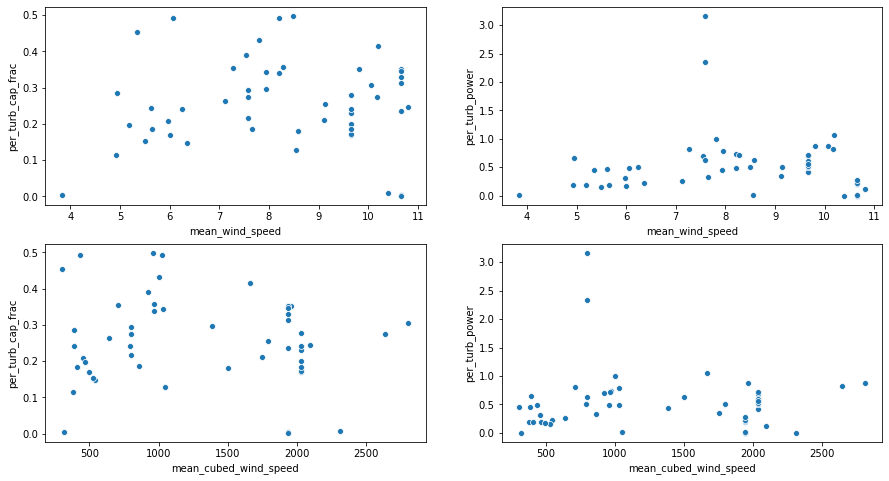

In [362]:
fig, axes = plt.subplots(2,2,figsize=(15,8))
sns.scatterplot(data=select_df,x='mean_wind_speed',y='per_turb_cap_frac',ax = axes[0,0]);
sns.scatterplot(data=select_df,x='mean_wind_speed',y='per_turb_power', ax = axes[0,1])
#axes[0,1].set_ylim(0,1)
#axes[1,1].set_ylim(0,1)
sns.scatterplot(data=select_df,x='mean_cubed_wind_speed',y='per_turb_cap_frac', ax = axes[1,0]); 
sns.scatterplot(data=select_df,x='mean_cubed_wind_speed',y='per_turb_power', ax = axes[1,1])

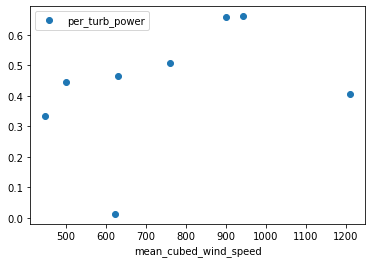

In [198]:
#select_df['mean_wind_speed'] = mean_wind_speeds
select_df['mean_cubed_wind_speed'] = mean_cubed_wind_speeds
select_df['per_turb_power'] = select_df['mean MW']/select_df['n_turbines']
select_df.plot(x='mean_cubed_wind_speed',y='per_turb_power',linestyle='',marker='o')

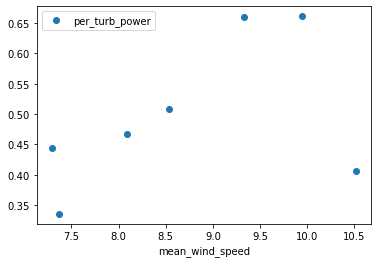

# mean rotor area

In [368]:
#t_rsa = swept area

Index(['index', 'case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id',
       't_state', 't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap',
       't_manu', 't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh',
       't_conf_atr', 't_conf_loc', 't_img_date', 't_img_srce', 'xlong',
       'ylat'],
      dtype='object')

In [388]:
select_turb_df[select_turb_df.p_name == 'Cemex Madison']['t_rsa']

480    4656.63
Name: t_rsa, dtype: float64

In [377]:
len(select_turb_df['p_name'].unique())

50

In [373]:
#there are significant diffrences in rotor area, and not much variance within-farm
area_stats = select_turb_df.groupby('p_name').agg({'t_rsa' : ['mean','std']})
area_stats

t_rsa            
                                                    mean         std
p_name                                                              
251 Wind                                             NaN         NaN
Alta I                                       4656.630000    0.000000
Alta II                                      6361.730000    0.000000
Alta III                                     6361.730000    0.000000
Alta IV                                      6361.730000    0.000000
Alta V                                       6361.730000    0.000000
Alta VIII (partial)                          6361.730000    0.000000
Alta X                                       8332.290000    0.000000
Alta XI                                      7922.310000  169.108122
Anheuser-Busch Fairfield                     5001.125000  487.189501
Buena Vista                                  2960.920000    0.000000
Cemex Black Mountain Quarry                  4656.630000    0.000000
Cemex Madison                                4656.630000         NaN
Cemex River Plant                            5345.620000    0.000000
City of Soledad Water Reclamation Facility   5345.620000         NaN
Coram Energy LLC                             4656.630000    0.000000
Difwind 1                                            NaN         NaN
Difwind 2                                            NaN         NaN
Difwind 5                                            NaN         NaN
Garnet Wind Project                          1256.640000    0.000000
Golden Acorn Casino                          5345.620000         NaN
Golden Hills                                 7853.980000    0.000000
Golden Hills North                          10568.320000    0.000000
Hatchett Ridge                               6792.910000    0.000000
High Winds                                   5026.550000    0.000000
Inland Empire Utility Agency                 2960.920000         NaN
Kumeyaay Phase I                             5944.680000    0.000000
Manzana Winds                                4656.630000    0.000000
Mesa Wind Farm                                183.850000    0.000000
Montezuma Winds II                           6792.910000    0.000000
Mountain View Power Partners I & II          1590.430000    0.000000
Mountain View Power Partners III             1734.940000    0.000000
Mustang Hills                                6361.730000    0.000000
Nestle Waters                                5345.620000    0.000000
Oak Creek Energy Systems                     4656.630000         NaN
Pacific Wind                                 6720.060000    0.000000
Pinyon Pines II                              6361.730000    0.000000
Robertsons Ready Mix                         5345.620000    0.000000
Safeway Tracy                                2960.920000    0.000000
San Gorgonio Westwinds II LLC                1744.295161  121.833521
Scheid Vineyards                             5345.620000         NaN
Solano Phase 3                               6361.730000    0.000000
Solano Phase IIA                             6361.730000    0.000000
Superior Farms                               2960.920000         NaN
Taylor Farms                                 5345.620000         NaN
Tule                                         8992.020000    0.000000
Vasco (repower)                              8011.850000    0.000000
Wagner                                       6361.730000    0.000000
Walmart Red Bluff                            4656.630000         NaN
Windstar                                     5378.499833  450.160441

In [374]:
select_df['mean area'] = area_stats[('t_rsa','mean')]

In [375]:
select_df.head()

,index,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh,...,cap_frac,NumberOfUnits,latitude,longitude,per_turb_power,per_turb_capacity,per_turb_cap_frac,mean_wind_speed,mean_cubed_wind_speed,mean area
0,106,2019.0,Terra-Gen Operating Company,57282,W0370,Alta I Wind Energy Center,CA,150.0,366369,366369,...,0.278929,100.0,35.0192,-118.3031,0.418393,1.5,0.278929,9.656256,2031.653931,NaN
1,107,2019.0,Terra-Gen Operating Company,57291,W0372,Alta II Wind Energy Center,CA,150.0,301923,301923,...,0.229864,50.0,35.0192,-118.3031,0.689592,3.0,0.229864,9.656256,2031.653931,NaN
2,108,2019.0,Terra-Gen Operating Company,57292,W0387,Alta III Wind Energy Center,CA,150.0,316458,316458,...,0.240930,50.0,35.0192,-118.3031,0.722790,3.0,0.240930,9.656256,2031.653931,NaN
3,109,2019.0,Terra-Gen Operating Company,57293,W0388,Alta IV Wind Energy Center,CA,102.0,152311,152311,...,0.170529,34.0,35.0192,-118.3031,0.511586,3.0,0.170529,9.656256,2031.653931,NaN
4,110,2019.0,Terra-Gen Operating Company,57294,W0389,Alta V Wind Energy Center,CA,168.0,253993,253993,...,0.172655,56.0,35.0192,-118.3031,0.517964,3.0,0.172655,9.656256,2031.653931,NaN


# include elevation data

In [202]:
import requests
import os

In [204]:
#stolen from https://gist.github.com/Alliages/a858a59b2487d81eb66c0c3b62d042be

def calc_elevation(lat, lng):
    apikey = os.environ["GOOGLE_API_KEY"]
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    request = requests.get(url+"?locations="+str(lat)+","+str(lng)+"&key="+apikey)
    try:
        results = request.json().get('results')
        if 0 < len(results):
            elevation = results[0].get('elevation')
            # ELEVATION
            return elevation
        else:
            print('HTTP GET Request failed.')
    except ValueError:
        print('JSON decode failed: '+str(request))
        
#test 
elevation(35.0192,-118.3031)

1036.13330078125

In [205]:
#compute elevation for each farm
select_df['elevation'] = select_df.apply(lambda row: calc_elevation(row['latitude'], row['longitude']),axis=1)

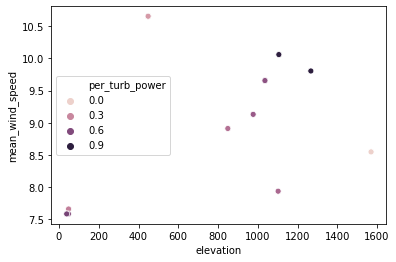

In [218]:
#some overlapping points here
sns.scatterplot(data=select_df,x='elevation',y='mean_wind_speed',hue='per_turb_power'); plt.show()

In [263]:
select_turb_df['p_name'].unique()

array(['251 Wind', 'Alta I', 'Alta II', 'Alta III', 'Alta IV', 'Alta V',
       'Alta X', 'Edom Hills (repower)', 'Coram Energy LLC', 'Windstar',
       'Pinyon Pines I', 'Pinyon Pines II', 'Manzana Winds', 'High Winds',
       'Shiloh II', 'Montezuma Winds II',
       'Mountain View Power Partners I & II',
       'Mountain View Power Partners III', 'Mountain View IV'],
      dtype=object)

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu',
       't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr',
       't_conf_loc', 't_img_date', 't_img_srce', 'xlong', 'ylat'],
      dtype='object')


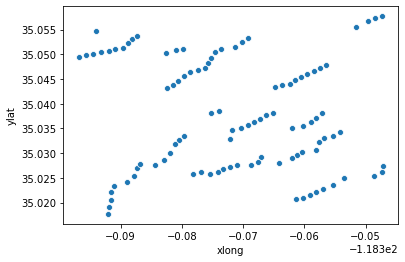

In [264]:
test_farm = ca_turb_df[ca_turb_df.p_name == 'Alta I']
print(test_farm.columns)
sns.scatterplot(data=test_farm,x = 'xlong',y='ylat')

We find that across the wind 251 wind farm, we have only 2 NREL geospatial points. Let's see how correlated these points are across time. Is it worth separating them out?

For Alta I, there are 9 unique points

In [265]:
test_idx_list = test_farm.apply(lambda row: indicesForCoord(f, row['ylat'], row['xlong']),axis=1)

In [271]:
unique_idx = test_idx_list.unique()
print(len(unique_idx))

9


In [267]:
test = np.array([get_speeds(loc_idx,get_year_idx(year)) for loc_idx in unique_idx])

probably not:

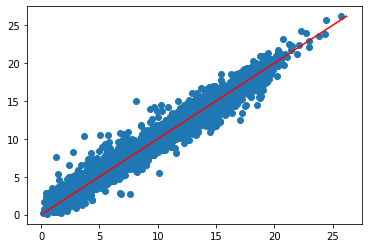

In [268]:
plt.scatter(test[0],test[1])
plt.plot([np.min(test[1]),np.max(test[1])],[np.min(test[1]),np.max(test[1])],c='red')

# comparing names

In [286]:
[len(x.unique()) for x in [gen_df['Plant Name'],farm_df['Facility Name']]]

[117, 166]

In [292]:
import itertools
name_match = pd.DataFrame(itertools.zip_longest(
    gen_df.sort_values('Plant Name')['Plant Name'].unique(),
    farm_df['Facility Name'].unique(),
    ca_turb_df['p_name'].unique(),fillvalue='-'))
#name_match.to_csv('name_match.csv')

In [176]:
gen_df[vec_str_in(gen_df['Plant Name'],'II')].sort_values('Gross MWh',ascending=False)
#gen_df.sort_values('Gross MWh',ascending=False).iloc[:20]

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
51,2019.0,Not Available,61582,W0471,"Voyager Wind II, LLC",CA,128.7,461824,461824
101,2019.0,Shiloh III Wind Project,56874,W0384,"Shiloh Wind Project 2, LLC (Shiloh II & III)",CA,153.8,383508,383508
108,2019.0,Terra-Gen Operating Company,57292,W0387,Alta III Wind Energy Center,CA,150.0,316458,316458
107,2019.0,Terra-Gen Operating Company,57291,W0372,Alta II Wind Energy Center,CA,150.0,301923,301923
80,2019.0,See WPRS for details,59236,W0438,Rising Tree Wind Farm III,CA,99.0,266475,266475
75,2019.0,See WPRS for details,Missing,W0421,"Shiloh III Wind Project, LLC",CA,102.5,266081,266081
0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116
113,2019.0,Terra-Gen Operating Company,57837,W0416,Pinyon Pines Winds II,CA,132.0,213748,213748
33,2019.0,NextEra Energy Resources LLC,57701,W0392,Montezuma Wind II,CA,78.2,188201,188201
52,2019.0,Not Available,61583,W0472,"Voyager Wind III, LLC",CA,43.2,136137,136137


In [153]:
farm_df[vec_str_in(farm_df['Facility Name'],'Pinyon')]

,index,Facility Name,Facility,FacilityType,Owner,Developer,EnergyPurchaser,Place,GeneratingCapacity,NumberOfUnits,CommercialOnlineDate,WindTurbineManufacturer,FacilityStatus,Coordinates,latitude,longitude
89,1123,Pinyon Pines I,Pinyon Pines I (Alta VII),Commercial Scale Wind,MidAmerican Energy,Terra-Gen Power LLC,Southern California Edison Co,Tehachapi Pass CA,168 MW,56.0,2012.0,Vestas,In Service,"35.0192°, -118.3031°",35.0192,-118.3031
90,1124,Pinyon Pines II,Pinyon Pines II (Alta IX),Commercial Scale Wind,MidAmerican Energy,Terra-Gen Power LLC,Southern California Edison Co,Tehachapi Pass CA,132 MW,44.0,2012.0,Vestas,In Service,"35.0192°, -118.3031°",35.0192,-118.3031


In [160]:
gen_df.iloc[:50]

,Year,Company Name,EIA\nPlant ID,CEC\nPlant ID,Plant Name,State,Capacity (MW),Gross MWh,Net MWh
0,2019.0,Alta Wind VIII LLC,57835,W0393,"Alta Wind VIII, LLC",CA,150.0,237116,237116
1,2019.0,BP Wind Energy North America,50553,W0391,"Edom Hills Project 1, LLC",CA,20.0,28500,28500
2,2019.0,CalWind Resources Inc,10191,W0284,Wind Resource I (Calwind Wind Resource I),CA,8.7,14038,14038
3,2019.0,CalWind Resources Inc,54909,W0320,Wind Resource II (Calwind),CA,20.0,47619,47619
4,2019.0,Coram California Development LP,57962,W0408,"Coram California Development, LP",CA,102.0,247038,247038
5,2019.0,Difwinds Farm Ltd V,54685,W0386,Difwind Farms LTD V,CA,3.1,6423,6423
6,2019.0,EUI Management PH Inc,10027,W0268,Windparks Unlimited 1 and 2,CA,25.2,37749,37749
7,2019.0,EverPower Wind Holdings Inc,57833,W0406,Mustang Hills LLC (Alta Wind VI Energy Center),CA,150.0,264160,264160
8,2019.0,Foundation Windpower,57594,W0395,Teichert Vernalis,CA,1.5,2006,2006
9,2019.0,Foundation Windpower,57626,W0396,Safeway Tracy,CA,2.0,2694,2694
